In [2]:
import os
import sys
import pathlib

import numpy as np
import pandas as pd

In [3]:
CURRENT_DIR = pathlib.Path(os.getcwd()).parent.parent
DATA_DIR = CURRENT_DIR / "data"
RANDOM_SEED = 42

In [4]:
sys.path.append(str(CURRENT_DIR))

from time_series_masters.data_analysis.clustering import cluster_ts, plot_clustered_series, find_optimal_n_clusters
from time_series_masters.data_analysis.utils import describe_ts, resample_ts, draw_resampled, calculate_slope

c:\Users\User\.conda\envs\tsururu\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


__В этом ноутбуке рассмотрены датасеты: fred_md.__

Если в датасете много рядов, и анализ в таком виде затруднителен, то мы прибегали к кластеризации рядов путем KMeans и DTW ([Dynamic Time Warping](https://rtavenar.github.io/blog/dtw.html)). Для определения оптимального числа кластеров мы использовали [Silhouette Score](https://tslearn.readthedocs.io/en/latest/gen_modules/clustering/tslearn.clustering.silhouette_score.html). Как использовать эту метрику, описано [здесь](https://builtin.com/data-science/elbow-method).

DTW достаточно тяжеловесный алгоритм, поэтому перед кластеризацией мы переходили к другой гранулярности.

После этого мы смотрели на то, как ведет себя ряд при ресемплировании к другим гранулярностям, а также пытались выявить наличие тренда, смены режима и других аномалий при помощи подсчета [коэффициента наклона в линейной регрессии](https://www.vortexa.com/insights/technology/detecting-trends-in-time-series-data-using-python/#:~:text=To%20detect%20an%20increasing%20trend,series%20has%20an%20increasing%20trend.).

### fred_md

Contains 107 monthly time series showing a set of macro-economic indicators from the Federal Reserve Bank.

In [5]:
fred_md = pd.read_csv(DATA_DIR / "fred_md.csv", parse_dates=["date"])
fred_md.head()

,id,date,value
0,0,1959-01-01,2437.296
1,0,1959-02-01,2446.902
2,0,1959-03-01,2462.689
3,0,1959-04-01,2478.744
4,0,1959-05-01,2493.228


Приведем основные необходимые характеристики ряда.

In [6]:
describe_ts(fred_md)

Число рядов: 107
Наблюдений в ряде: [728]
Частота ряда: monthly
Минимальная дата в ряде: 1959-01-01 00:00:00
Максимальная дата в ряде: 2019-08-01 00:00:00, 

count    7.789600e+04
mean     1.907781e+04
std      1.072463e+05
min     -3.335210e+05
25%      1.940540e+01
50%      1.010682e+02
75%      1.789000e+03
max      2.841761e+06
Name: value, dtype: float64


Рядов много. Попробуем их кластеризовать.

c:\Users\User\.conda\envs\tsururu\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 107 1-dimensional timeseries
  warnings.warn(
c:\Users\User\.conda\envs\tsururu\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 107 1-dimensional timeseries
  warnings.warn(
c:\Users\User\.conda\envs\tsururu\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 107 1-dimensional timeseries
  warnings.warn(
c:\Users\User\.conda\envs\tsururu\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 107 1-dimensional timeseries
  warnings.warn(
c:\Users\User\.conda\envs\tsururu\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 107 1-dimensional timeseries
  warnings.warn(
c:\Users\User\.conda\envs\tsururu\lib\site-packages\tslearn\utils\utils.py:90: U

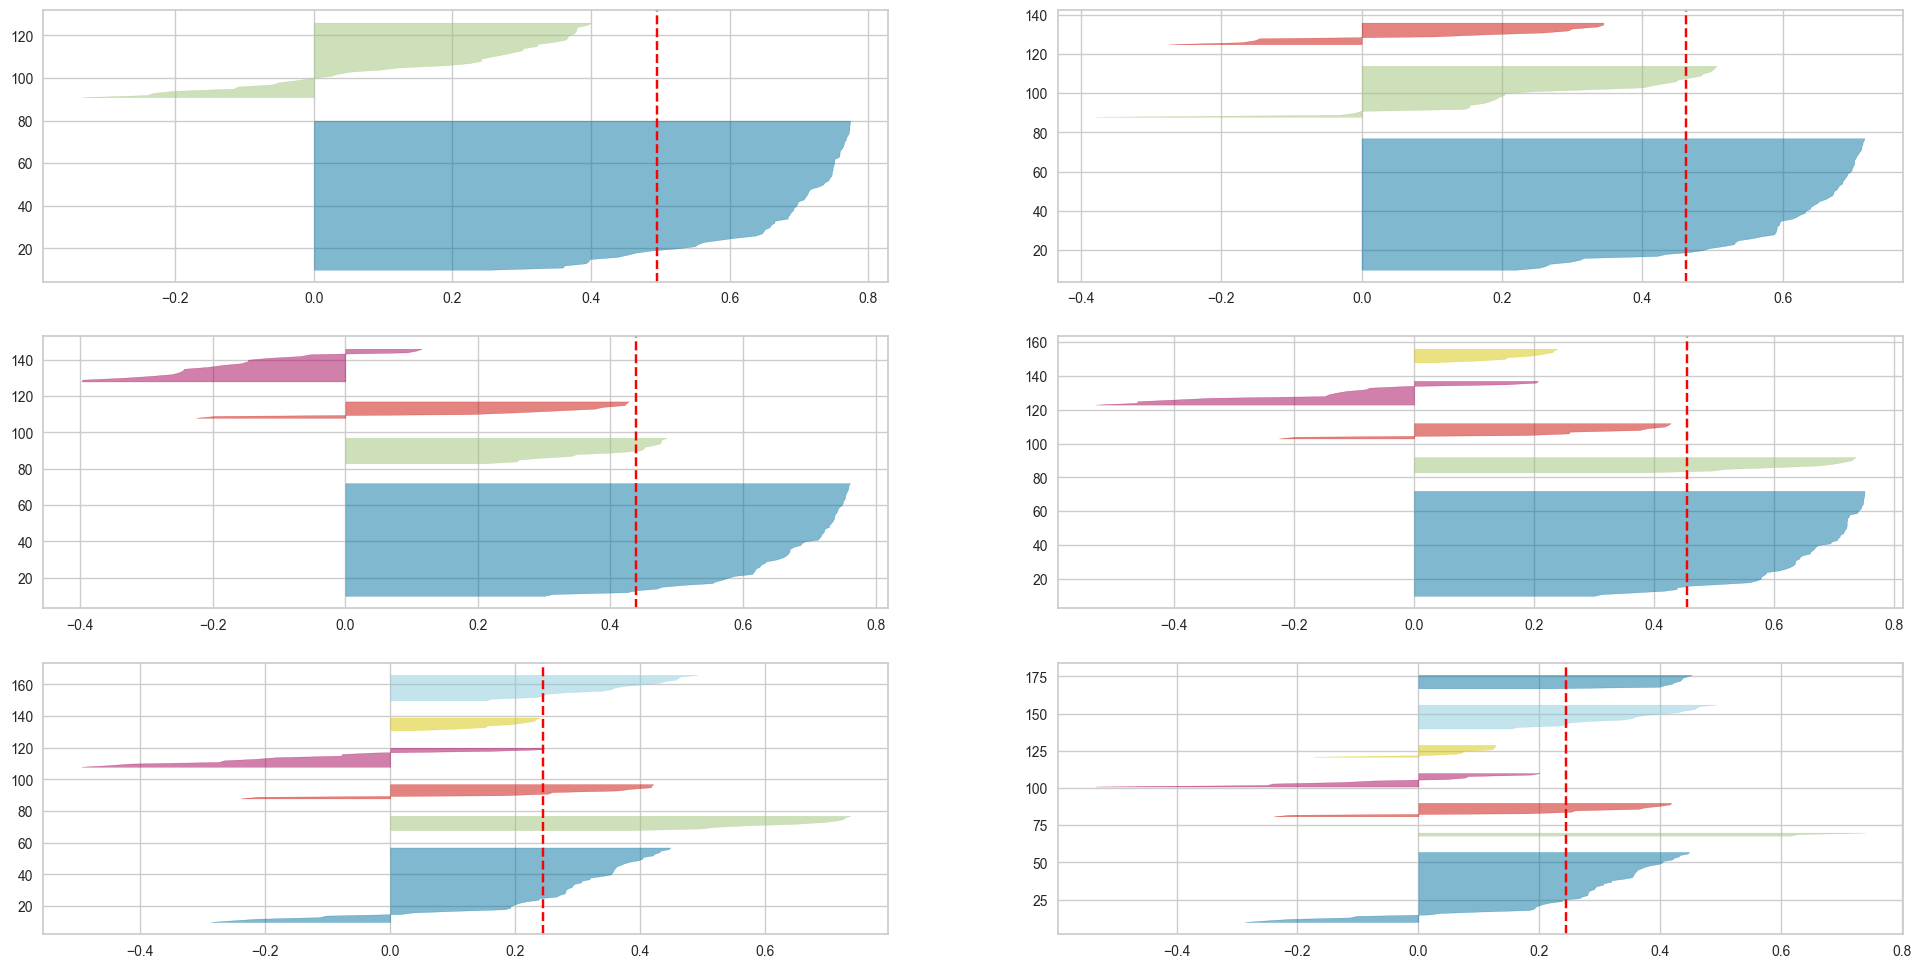

In [8]:
find_optimal_n_clusters(fred_md, "dtw", 7)

Кажется, что наиболее правдоподобно разделить на 6 кластеров.

In [9]:
def make_cluster_df(data, data_full, metric, n_clusters, n_jobs):
    df_k = cluster_ts(data, metric, n_clusters, n_jobs=n_jobs)
    df_k_id_cluster_dict = {ts_id: cluster for ts_id, cluster in df_k[["id", "cluster"]].values} 
    df_k_full = data_full.copy()
    df_k_full["cluster"] = df_k_full["id"].map(df_k_id_cluster_dict)
    return df_k_full

In [12]:
df_k_6 = make_cluster_df(fred_md, fred_md, "dtw", 6, -1)

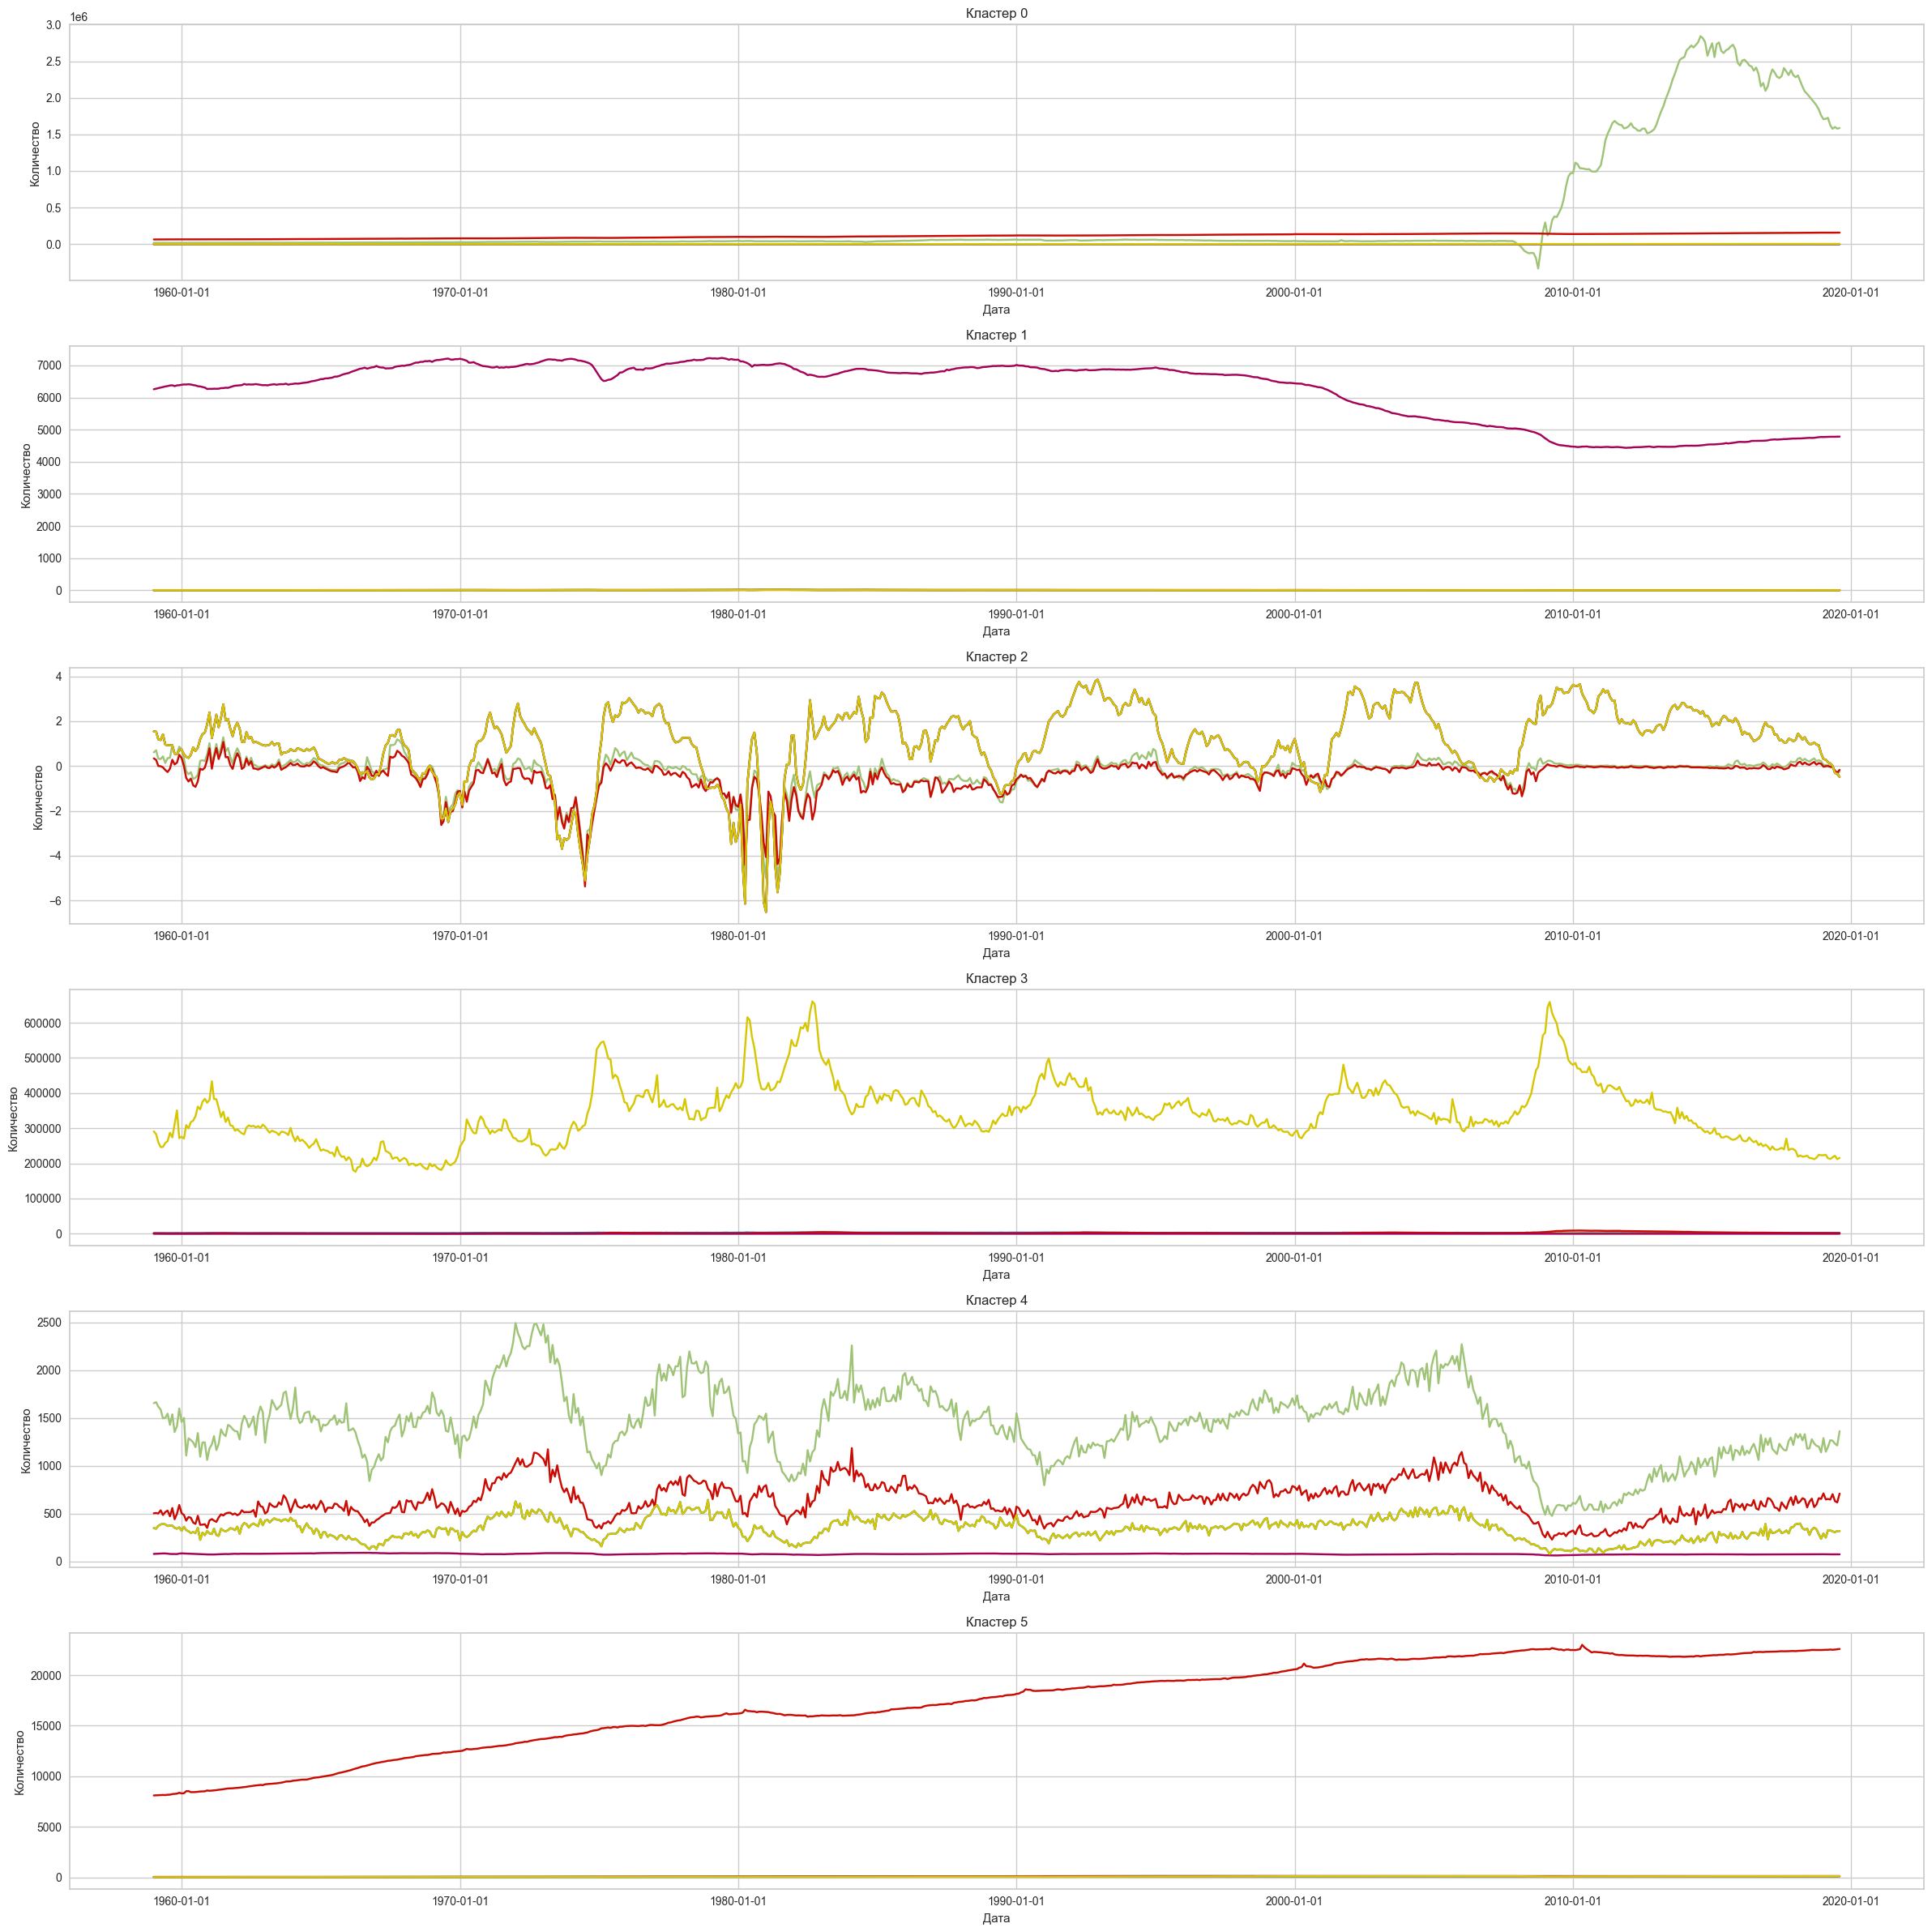

In [13]:
plot_clustered_series(df_k_6, 6, n_series=5)

Видно, что некоторые кластеры получились однородными, а некоторые все равно остались довольно разнородными.

Возьмем по одному ряду из каждого кластера.

In [14]:
np.random.seed(RANDOM_SEED)

id_list = []
for cluster in range(6):
    id_list.append(df_k_6[df_k_6["cluster"] == cluster]["id"].sample().values[0])

df_k_3_short = df_k_6[df_k_6["id"].isin(id_list)].copy()

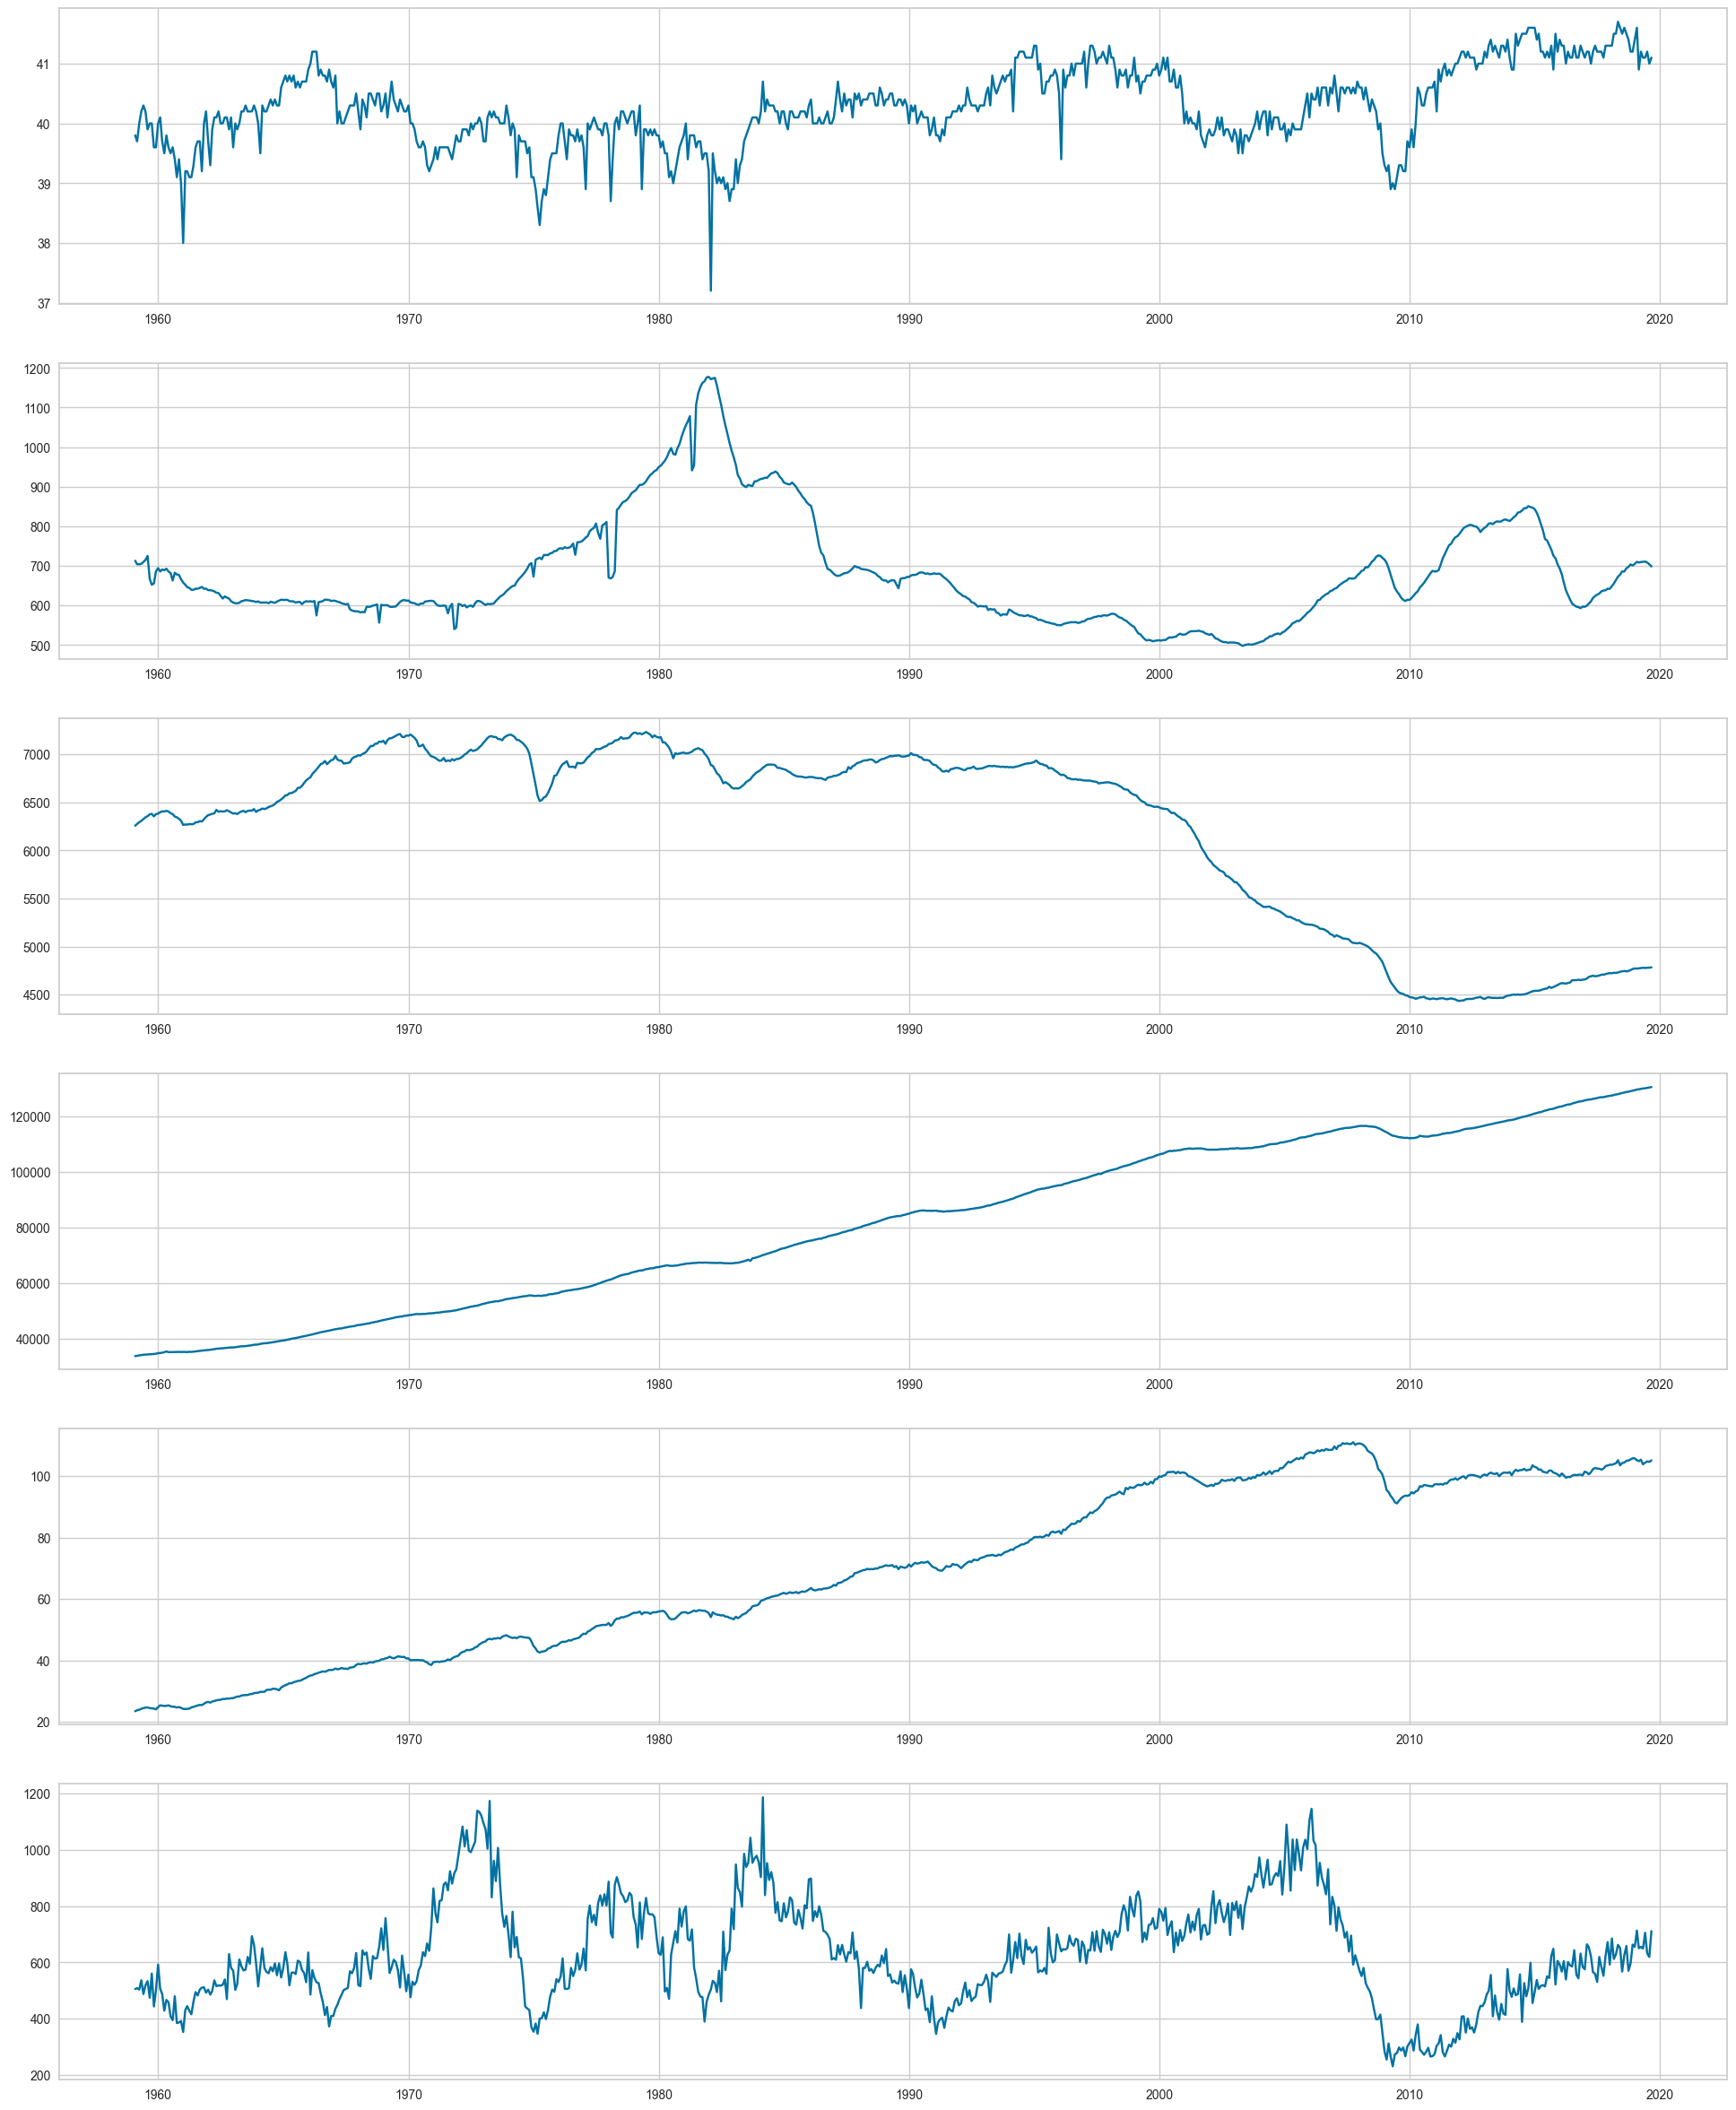

In [15]:
draw_resampled(df_k_3_short, 'M', 6)

In [16]:
# Perform Linear Regression and calculate the gradient/slope
lr_df = calculate_slope(fred_md, location_col = 'id', quantity_col = 'value', location_list = fred_md['id'].unique())

In [18]:
lr_df.sort_values("gradient", key = lambda x: abs(x), ascending=False)[['gradient']].iloc[:10].style.bar(subset = 'gradient',align='mid', color=['#d65f5f', '#5fba7d'])

,gradient
60,2267.776548
54,1561.402095
41,695.447387
53,358.881138
18,142.999675
37,140.391782
29,139.267753
20,134.392678
28,69.396617
38,25.209485


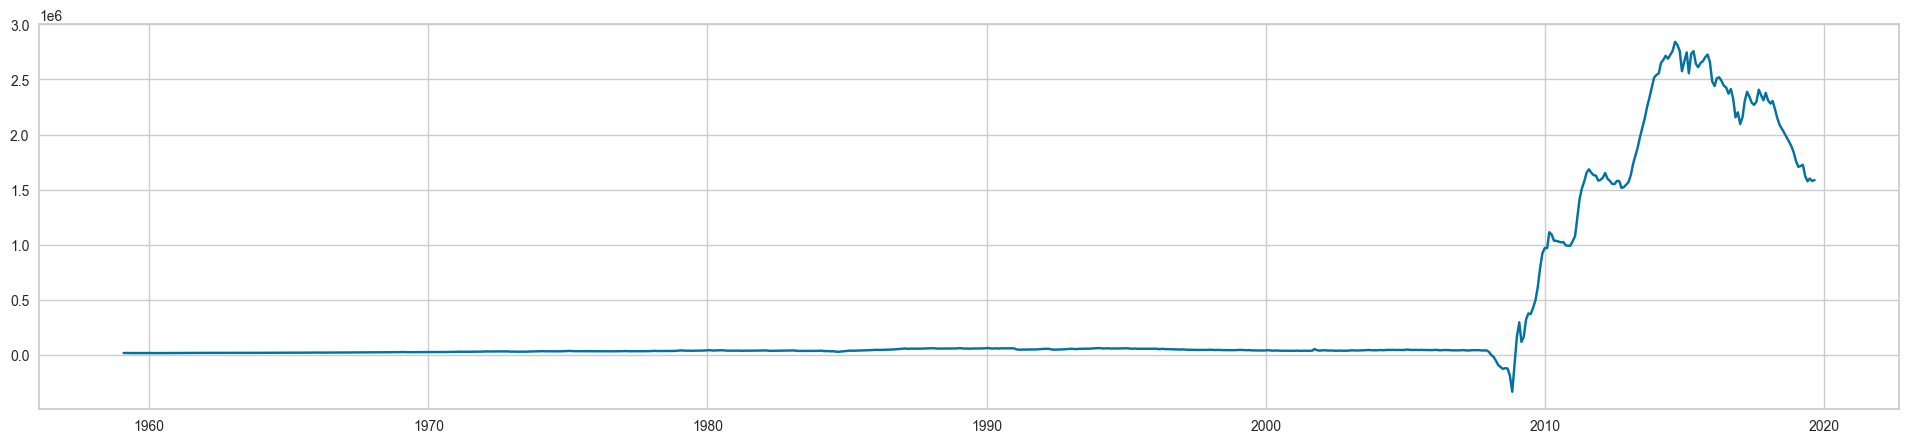

In [19]:
draw_resampled(fred_md[fred_md['id'] == 60], 'M', 1)

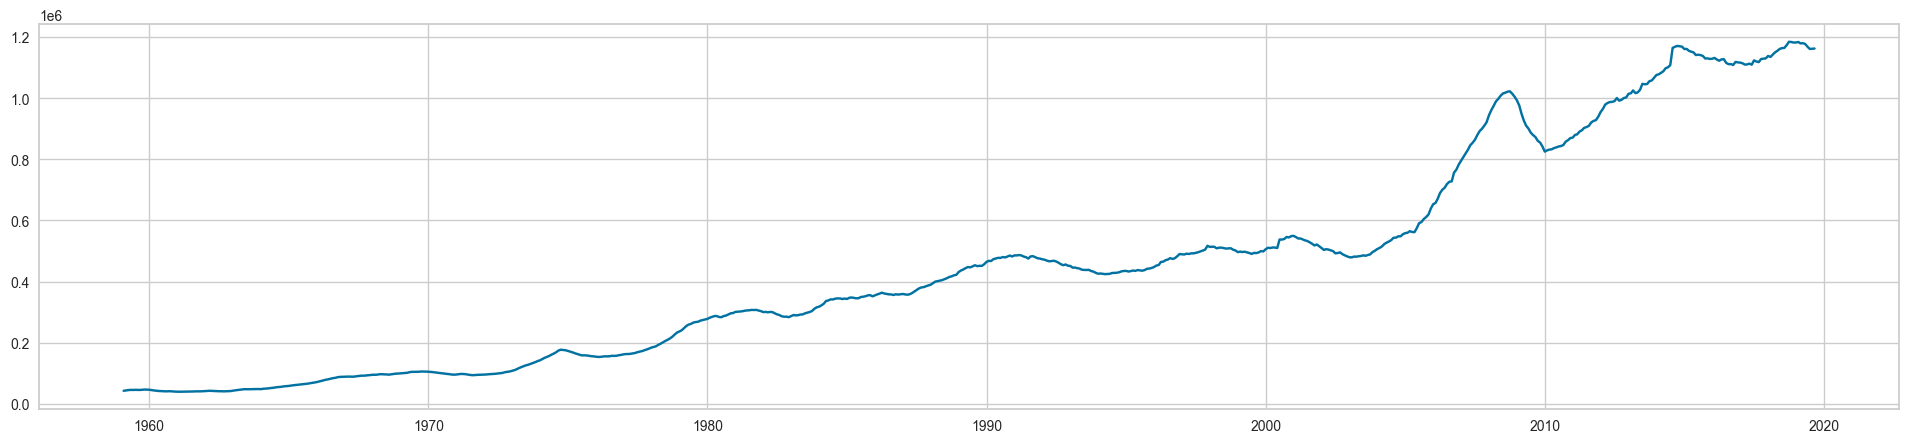

In [20]:
draw_resampled(fred_md[fred_md['id'] == 54], 'M', 1)

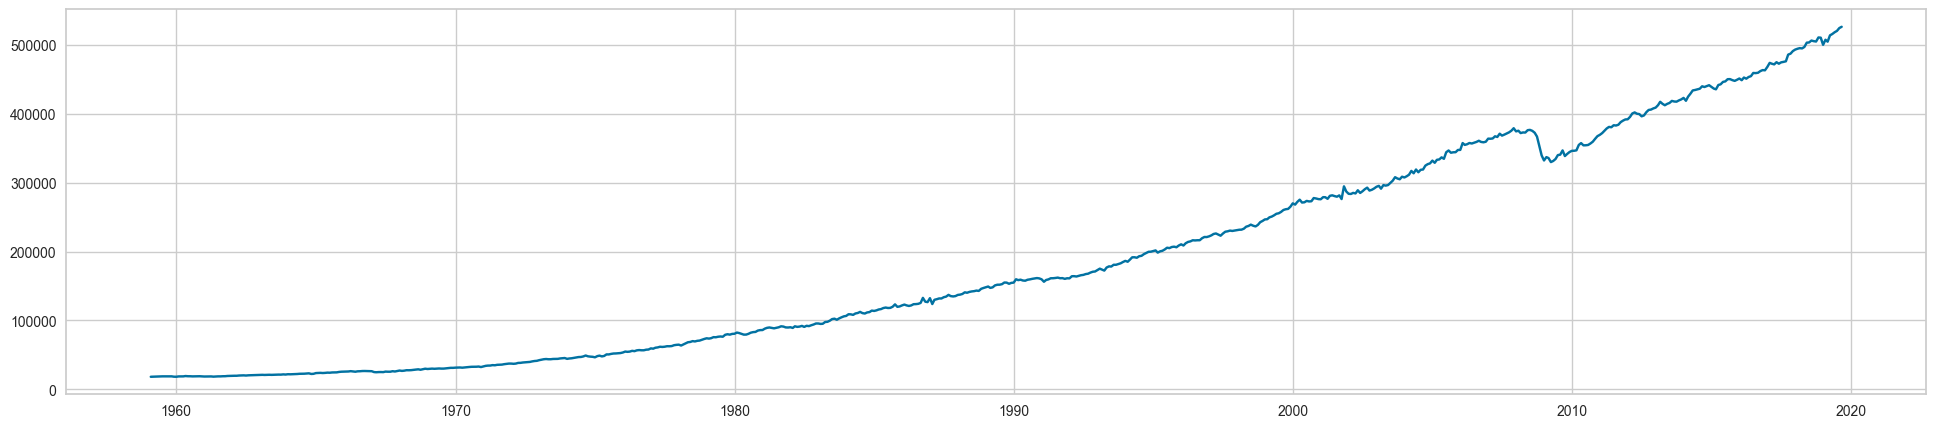

In [21]:
draw_resampled(fred_md[fred_md['id'] == 41], 'M', 1)

__Вывод:__ Ряды разнородные. В некоторых наблюдается тренд. О сезонности трудно что-либо сказать.